In [2]:
import tensorflow as tf
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

In [4]:
dataset_path = tf.keras.utils.get_file("auto-mpg.data","http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
dataset_path

32768/30286 [================================] - 0s 5us/step


'/Users/nicolasmakaroff/.keras/datasets/auto-mpg.data'

In [5]:
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'Model Year', 'Origin']
dataset = pd.read_csv(dataset_path, names=column_names,
                      na_values = "?", comment='\t',
                      sep=" ", skipinitialspace=True)

dataset = dataset.copy()
dataset.tail()


,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


In [6]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [7]:
dataset = dataset.dropna()

In [8]:
dataset['Origin'] = dataset['Origin'].map(lambda x: {1: 'USA', 2: 'Europe', 3: 'Japan'}.get(x))

In [10]:
dataset = pd.get_dummies(dataset, prefix='',prefix_sep='')
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
393,27.0,4,140.0,86.0,2790.0,15.6,82,0,0,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,1,0,0
395,32.0,4,135.0,84.0,2295.0,11.6,82,0,0,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,0,0,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,0,0,1


In [11]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

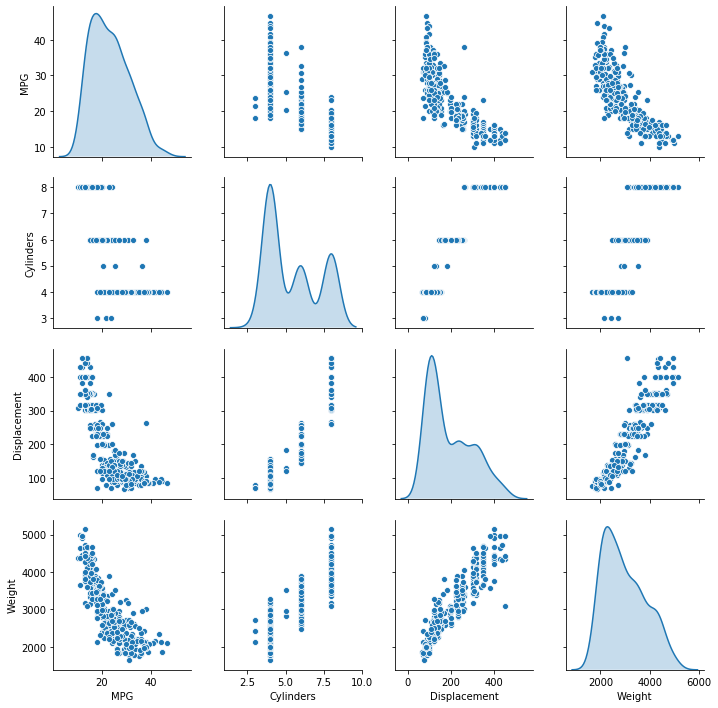

In [12]:
sns.pairplot(train_dataset[["MPG","Cylinders","Displacement","Weight"]],diag_kind="kde")

In [13]:
train_stats = train_dataset.describe()
train_stats.pop("MPG")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0


In [14]:
train_labels = train_dataset.pop("MPG")
test_labels = test_dataset.pop("MPG")

In [15]:
def norm(x):
    return (x - train_stats['mean'])/train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

In [33]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(64, activation='relu',input_shape=[len(train_dataset.keys())]),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(1)
    ])
    
    optimizer = tf.keras.optimizers.RMSprop(0.001)
    
    model.compile(loss='mse', optimizer='adam',metrics=['mae','mse'])
    
    return model

In [34]:
model = build_model()

In [35]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 64)                640       
_________________________________________________________________
dense_10 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 65        
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


In [36]:
example_batch = normed_train_data[:10]
example_batch = model.predict(example_batch)
example_batch

array([[ 0.20666488],
       [ 0.02292554],
       [ 0.14827758],
       [ 0.24800731],
       [ 0.28894523],
       [-0.074211  ],
       [ 0.3251833 ],
       [ 0.3063661 ],
       [ 0.02648008],
       [ 0.43474334]], dtype=float32)

In [37]:
EPOCHS = 1000

history = model.fit(normed_train_data, train_labels, epochs = EPOCHS, validation_split = 0.2)

Train on 251 samples, validate on 63 samples
Epoch 1/1000
251/251 [==============================] - 0s 489us/sample - loss: 572.4891 - mae: 22.6833 - mse: 572.4891 - val_loss: 576.4910 - val_mae: 22.7314 - val_mse: 576.4911
Epoch 2/1000
251/251 [==============================] - 0s 47us/sample - loss: 542.2348 - mae: 21.9944 - mse: 542.2348 - val_loss: 541.6222 - val_mae: 21.9404 - val_mse: 541.6222
Epoch 3/1000
251/251 [==============================] - 0s 49us/sample - loss: 508.5055 - mae: 21.2105 - mse: 508.5055 - val_loss: 501.0426 - val_mae: 20.9949 - val_mse: 501.0426
Epoch 4/1000
251/251 [==============================] - 0s 43us/sample - loss: 468.9022 - mae: 20.2637 - mse: 468.9022 - val_loss: 452.7850 - val_mae: 19.8240 - val_mse: 452.7850
Epoch 5/1000
251/251 [==============================] - 0s 59us/sample - loss: 422.0663 - mae: 19.0920 - mse: 422.0663 - val_loss: 395.5911 - val_mae: 18.3376 - val_mse: 395.5912
Epoch 6/1000
251/251 [==============================] - 0s 

Epoch 47/1000
251/251 [==============================] - 0s 58us/sample - loss: 8.3372 - mae: 2.0679 - mse: 8.3372 - val_loss: 10.1749 - val_mae: 2.5378 - val_mse: 10.1749
Epoch 48/1000
251/251 [==============================] - 0s 47us/sample - loss: 8.2812 - mae: 2.0618 - mse: 8.2812 - val_loss: 10.1194 - val_mae: 2.5293 - val_mse: 10.1194
Epoch 49/1000
251/251 [==============================] - 0s 59us/sample - loss: 8.1862 - mae: 2.0510 - mse: 8.1862 - val_loss: 10.1578 - val_mae: 2.5180 - val_mse: 10.1578
Epoch 50/1000
251/251 [==============================] - 0s 67us/sample - loss: 8.1517 - mae: 2.0537 - mse: 8.1517 - val_loss: 10.1327 - val_mae: 2.5118 - val_mse: 10.1327
Epoch 51/1000
251/251 [==============================] - 0s 48us/sample - loss: 8.1377 - mae: 2.0480 - mse: 8.1377 - val_loss: 10.0489 - val_mae: 2.5139 - val_mse: 10.0489
Epoch 52/1000
251/251 [==============================] - 0s 55us/sample - loss: 8.0543 - mae: 2.0293 - mse: 8.0543 - val_loss: 10.0481 - val

251/251 [==============================] - 0s 45us/sample - loss: 6.7652 - mae: 1.8497 - mse: 6.7652 - val_loss: 8.9811 - val_mae: 2.3095 - val_mse: 8.9811
Epoch 96/1000
251/251 [==============================] - 0s 40us/sample - loss: 6.7940 - mae: 1.8644 - mse: 6.7940 - val_loss: 8.9795 - val_mae: 2.3049 - val_mse: 8.9795
Epoch 97/1000
251/251 [==============================] - 0s 44us/sample - loss: 6.6773 - mae: 1.8458 - mse: 6.6773 - val_loss: 8.9171 - val_mae: 2.3042 - val_mse: 8.9171
Epoch 98/1000
251/251 [==============================] - 0s 42us/sample - loss: 6.7578 - mae: 1.8355 - mse: 6.7578 - val_loss: 8.9102 - val_mae: 2.3293 - val_mse: 8.9102
Epoch 99/1000
251/251 [==============================] - 0s 43us/sample - loss: 6.6700 - mae: 1.8245 - mse: 6.6700 - val_loss: 8.8650 - val_mae: 2.2966 - val_mse: 8.8650
Epoch 100/1000
251/251 [==============================] - 0s 51us/sample - loss: 6.6954 - mae: 1.8546 - mse: 6.6954 - val_loss: 8.9274 - val_mae: 2.2914 - val_mse: 

251/251 [==============================] - 0s 42us/sample - loss: 6.1095 - mae: 1.7273 - mse: 6.1095 - val_loss: 8.3039 - val_mae: 2.2370 - val_mse: 8.3039
Epoch 144/1000
251/251 [==============================] - 0s 45us/sample - loss: 6.1439 - mae: 1.7464 - mse: 6.1439 - val_loss: 8.1901 - val_mae: 2.2058 - val_mse: 8.1901
Epoch 145/1000
251/251 [==============================] - 0s 43us/sample - loss: 6.0536 - mae: 1.7416 - mse: 6.0536 - val_loss: 8.2094 - val_mae: 2.2042 - val_mse: 8.2094
Epoch 146/1000
251/251 [==============================] - 0s 44us/sample - loss: 6.0540 - mae: 1.7351 - mse: 6.0540 - val_loss: 8.2732 - val_mae: 2.2118 - val_mse: 8.2732
Epoch 147/1000
251/251 [==============================] - 0s 40us/sample - loss: 6.0647 - mae: 1.7281 - mse: 6.0647 - val_loss: 8.2774 - val_mae: 2.2159 - val_mse: 8.2774
Epoch 148/1000
251/251 [==============================] - 0s 42us/sample - loss: 6.0397 - mae: 1.7255 - mse: 6.0397 - val_loss: 8.3037 - val_mae: 2.2168 - val_m

Epoch 191/1000
251/251 [==============================] - 0s 42us/sample - loss: 5.7856 - mae: 1.6687 - mse: 5.7856 - val_loss: 7.8821 - val_mae: 2.1828 - val_mse: 7.8821
Epoch 192/1000
251/251 [==============================] - 0s 41us/sample - loss: 5.7845 - mae: 1.6747 - mse: 5.7845 - val_loss: 7.8048 - val_mae: 2.1318 - val_mse: 7.8048
Epoch 193/1000
251/251 [==============================] - 0s 40us/sample - loss: 5.7137 - mae: 1.6796 - mse: 5.7137 - val_loss: 7.8492 - val_mae: 2.1547 - val_mse: 7.8492
Epoch 194/1000
251/251 [==============================] - 0s 41us/sample - loss: 5.7169 - mae: 1.6708 - mse: 5.7169 - val_loss: 7.8165 - val_mae: 2.1684 - val_mse: 7.8165
Epoch 195/1000
251/251 [==============================] - 0s 42us/sample - loss: 5.7291 - mae: 1.6707 - mse: 5.7291 - val_loss: 7.8114 - val_mae: 2.1458 - val_mse: 7.8114
Epoch 196/1000
251/251 [==============================] - 0s 41us/sample - loss: 5.7284 - mae: 1.6595 - mse: 5.7284 - val_loss: 7.8891 - val_mae:

Epoch 239/1000
251/251 [==============================] - 0s 41us/sample - loss: 5.5166 - mae: 1.6388 - mse: 5.5166 - val_loss: 7.6084 - val_mae: 2.1018 - val_mse: 7.6084
Epoch 240/1000
251/251 [==============================] - 0s 42us/sample - loss: 5.5456 - mae: 1.6411 - mse: 5.5456 - val_loss: 7.5650 - val_mae: 2.1265 - val_mse: 7.5650
Epoch 241/1000
251/251 [==============================] - 0s 43us/sample - loss: 5.5145 - mae: 1.6159 - mse: 5.5145 - val_loss: 7.6627 - val_mae: 2.1493 - val_mse: 7.6627
Epoch 242/1000
251/251 [==============================] - 0s 43us/sample - loss: 5.5713 - mae: 1.6359 - mse: 5.5713 - val_loss: 7.6817 - val_mae: 2.0856 - val_mse: 7.6817
Epoch 243/1000
251/251 [==============================] - 0s 41us/sample - loss: 5.5892 - mae: 1.6218 - mse: 5.5892 - val_loss: 7.5925 - val_mae: 2.1380 - val_mse: 7.5925
Epoch 244/1000
251/251 [==============================] - 0s 39us/sample - loss: 5.4695 - mae: 1.6120 - mse: 5.4695 - val_loss: 7.5453 - val_mae:

Epoch 287/1000
251/251 [==============================] - 0s 44us/sample - loss: 5.3367 - mae: 1.6001 - mse: 5.3367 - val_loss: 7.5475 - val_mae: 2.1257 - val_mse: 7.5475
Epoch 288/1000
251/251 [==============================] - 0s 42us/sample - loss: 5.3789 - mae: 1.5933 - mse: 5.3789 - val_loss: 7.4537 - val_mae: 2.0962 - val_mse: 7.4537
Epoch 289/1000
251/251 [==============================] - 0s 44us/sample - loss: 5.2689 - mae: 1.5773 - mse: 5.2689 - val_loss: 7.4713 - val_mae: 2.0976 - val_mse: 7.4713
Epoch 290/1000
251/251 [==============================] - 0s 48us/sample - loss: 5.2774 - mae: 1.5789 - mse: 5.2774 - val_loss: 7.5977 - val_mae: 2.1178 - val_mse: 7.5977
Epoch 291/1000
251/251 [==============================] - 0s 50us/sample - loss: 5.3373 - mae: 1.5930 - mse: 5.3373 - val_loss: 7.5172 - val_mae: 2.1051 - val_mse: 7.5172
Epoch 292/1000
251/251 [==============================] - 0s 45us/sample - loss: 5.2535 - mae: 1.5791 - mse: 5.2535 - val_loss: 7.6084 - val_mae:

Epoch 335/1000
251/251 [==============================] - 0s 43us/sample - loss: 5.1460 - mae: 1.5549 - mse: 5.1460 - val_loss: 7.4271 - val_mae: 2.0720 - val_mse: 7.4271
Epoch 336/1000
251/251 [==============================] - 0s 49us/sample - loss: 5.1632 - mae: 1.5478 - mse: 5.1632 - val_loss: 7.4949 - val_mae: 2.1009 - val_mse: 7.4949
Epoch 337/1000
251/251 [==============================] - 0s 44us/sample - loss: 5.1483 - mae: 1.5451 - mse: 5.1483 - val_loss: 7.6061 - val_mae: 2.1110 - val_mse: 7.6061
Epoch 338/1000
251/251 [==============================] - 0s 45us/sample - loss: 5.1637 - mae: 1.5729 - mse: 5.1637 - val_loss: 7.5550 - val_mae: 2.0697 - val_mse: 7.5550
Epoch 339/1000
251/251 [==============================] - 0s 44us/sample - loss: 5.2108 - mae: 1.5690 - mse: 5.2108 - val_loss: 7.4798 - val_mae: 2.1123 - val_mse: 7.4798
Epoch 340/1000
251/251 [==============================] - 0s 42us/sample - loss: 5.1014 - mae: 1.5381 - mse: 5.1014 - val_loss: 7.5215 - val_mae:

Epoch 383/1000
251/251 [==============================] - 0s 44us/sample - loss: 5.2355 - mae: 1.5606 - mse: 5.2355 - val_loss: 7.7944 - val_mae: 2.0777 - val_mse: 7.7944
Epoch 384/1000
251/251 [==============================] - 0s 46us/sample - loss: 5.0070 - mae: 1.5365 - mse: 5.0070 - val_loss: 7.6115 - val_mae: 2.1310 - val_mse: 7.6115
Epoch 385/1000
251/251 [==============================] - 0s 42us/sample - loss: 4.9951 - mae: 1.5052 - mse: 4.9951 - val_loss: 7.6106 - val_mae: 2.1169 - val_mse: 7.6106
Epoch 386/1000
251/251 [==============================] - 0s 41us/sample - loss: 4.9763 - mae: 1.5267 - mse: 4.9763 - val_loss: 7.5212 - val_mae: 2.0809 - val_mse: 7.5212
Epoch 387/1000
251/251 [==============================] - 0s 40us/sample - loss: 4.9717 - mae: 1.5320 - mse: 4.9717 - val_loss: 7.5690 - val_mae: 2.1085 - val_mse: 7.5690
Epoch 388/1000
251/251 [==============================] - 0s 42us/sample - loss: 4.9812 - mae: 1.5150 - mse: 4.9812 - val_loss: 7.6790 - val_mae:

Epoch 431/1000
251/251 [==============================] - 0s 43us/sample - loss: 4.8386 - mae: 1.4813 - mse: 4.8386 - val_loss: 7.5158 - val_mae: 2.1085 - val_mse: 7.5158
Epoch 432/1000
251/251 [==============================] - 0s 44us/sample - loss: 4.8553 - mae: 1.4727 - mse: 4.8553 - val_loss: 7.6319 - val_mae: 2.1155 - val_mse: 7.6319
Epoch 433/1000
251/251 [==============================] - 0s 43us/sample - loss: 4.8641 - mae: 1.5129 - mse: 4.8641 - val_loss: 7.7545 - val_mae: 2.0822 - val_mse: 7.7545
Epoch 434/1000
251/251 [==============================] - 0s 41us/sample - loss: 4.8774 - mae: 1.5195 - mse: 4.8774 - val_loss: 7.6346 - val_mae: 2.1305 - val_mse: 7.6346
Epoch 435/1000
251/251 [==============================] - 0s 40us/sample - loss: 4.8617 - mae: 1.4875 - mse: 4.8617 - val_loss: 7.6564 - val_mae: 2.1163 - val_mse: 7.6564
Epoch 436/1000
251/251 [==============================] - 0s 40us/sample - loss: 4.8084 - mae: 1.4825 - mse: 4.8084 - val_loss: 7.6673 - val_mae:

Epoch 479/1000
251/251 [==============================] - 0s 43us/sample - loss: 4.6981 - mae: 1.4510 - mse: 4.6981 - val_loss: 7.5495 - val_mae: 2.0862 - val_mse: 7.5495
Epoch 480/1000
251/251 [==============================] - 0s 43us/sample - loss: 4.7211 - mae: 1.4443 - mse: 4.7211 - val_loss: 7.5553 - val_mae: 2.0917 - val_mse: 7.5553
Epoch 481/1000
251/251 [==============================] - 0s 41us/sample - loss: 4.7000 - mae: 1.4736 - mse: 4.7000 - val_loss: 7.6107 - val_mae: 2.0734 - val_mse: 7.6107
Epoch 482/1000
251/251 [==============================] - 0s 40us/sample - loss: 4.6231 - mae: 1.4381 - mse: 4.6231 - val_loss: 7.6404 - val_mae: 2.1026 - val_mse: 7.6404
Epoch 483/1000
251/251 [==============================] - 0s 39us/sample - loss: 4.6417 - mae: 1.4484 - mse: 4.6417 - val_loss: 7.6567 - val_mae: 2.0967 - val_mse: 7.6567
Epoch 484/1000
251/251 [==============================] - 0s 41us/sample - loss: 4.6457 - mae: 1.4502 - mse: 4.6457 - val_loss: 7.6405 - val_mae:

Epoch 527/1000
251/251 [==============================] - 0s 50us/sample - loss: 4.5314 - mae: 1.4257 - mse: 4.5314 - val_loss: 7.8037 - val_mae: 2.1418 - val_mse: 7.8037
Epoch 528/1000
251/251 [==============================] - 0s 48us/sample - loss: 4.5870 - mae: 1.4192 - mse: 4.5870 - val_loss: 7.7407 - val_mae: 2.0959 - val_mse: 7.7407
Epoch 529/1000
251/251 [==============================] - 0s 43us/sample - loss: 4.6384 - mae: 1.4116 - mse: 4.6384 - val_loss: 7.7765 - val_mae: 2.1433 - val_mse: 7.7765
Epoch 530/1000
251/251 [==============================] - 0s 45us/sample - loss: 4.4889 - mae: 1.4206 - mse: 4.4889 - val_loss: 7.8688 - val_mae: 2.0979 - val_mse: 7.8688
Epoch 531/1000
251/251 [==============================] - 0s 54us/sample - loss: 4.6204 - mae: 1.4416 - mse: 4.6204 - val_loss: 7.7468 - val_mae: 2.1242 - val_mse: 7.7468
Epoch 532/1000
251/251 [==============================] - 0s 49us/sample - loss: 4.4651 - mae: 1.4118 - mse: 4.4651 - val_loss: 7.8619 - val_mae:

Epoch 575/1000
251/251 [==============================] - 0s 42us/sample - loss: 4.3682 - mae: 1.4029 - mse: 4.3682 - val_loss: 7.7967 - val_mae: 2.1203 - val_mse: 7.7967
Epoch 576/1000
251/251 [==============================] - 0s 46us/sample - loss: 4.3519 - mae: 1.3808 - mse: 4.3519 - val_loss: 7.7528 - val_mae: 2.1251 - val_mse: 7.7528
Epoch 577/1000
251/251 [==============================] - 0s 45us/sample - loss: 4.5150 - mae: 1.4236 - mse: 4.5150 - val_loss: 7.7868 - val_mae: 2.0872 - val_mse: 7.7868
Epoch 578/1000
251/251 [==============================] - 0s 43us/sample - loss: 4.3465 - mae: 1.3993 - mse: 4.3465 - val_loss: 7.9214 - val_mae: 2.1693 - val_mse: 7.9214
Epoch 579/1000
251/251 [==============================] - 0s 43us/sample - loss: 4.4088 - mae: 1.3736 - mse: 4.4088 - val_loss: 7.7658 - val_mae: 2.0882 - val_mse: 7.7658
Epoch 580/1000
251/251 [==============================] - 0s 39us/sample - loss: 4.3640 - mae: 1.3932 - mse: 4.3640 - val_loss: 7.7388 - val_mae:

Epoch 623/1000
251/251 [==============================] - 0s 43us/sample - loss: 4.1976 - mae: 1.3552 - mse: 4.1976 - val_loss: 7.7872 - val_mae: 2.1032 - val_mse: 7.7872
Epoch 624/1000
251/251 [==============================] - 0s 45us/sample - loss: 4.4005 - mae: 1.3610 - mse: 4.4005 - val_loss: 7.9078 - val_mae: 2.1715 - val_mse: 7.9078
Epoch 625/1000
251/251 [==============================] - 0s 45us/sample - loss: 4.3345 - mae: 1.3982 - mse: 4.3345 - val_loss: 8.0381 - val_mae: 2.1103 - val_mse: 8.0381
Epoch 626/1000
251/251 [==============================] - 0s 57us/sample - loss: 4.3341 - mae: 1.3749 - mse: 4.3341 - val_loss: 7.8211 - val_mae: 2.1553 - val_mse: 7.8211
Epoch 627/1000
251/251 [==============================] - 0s 57us/sample - loss: 4.2660 - mae: 1.3678 - mse: 4.2660 - val_loss: 7.8548 - val_mae: 2.1280 - val_mse: 7.8548
Epoch 628/1000
251/251 [==============================] - 0s 41us/sample - loss: 4.2147 - mae: 1.3494 - mse: 4.2147 - val_loss: 7.8365 - val_mae:

Epoch 671/1000
251/251 [==============================] - 0s 44us/sample - loss: 4.0438 - mae: 1.3175 - mse: 4.0438 - val_loss: 7.7613 - val_mae: 2.1192 - val_mse: 7.7613
Epoch 672/1000
251/251 [==============================] - 0s 43us/sample - loss: 4.0930 - mae: 1.3376 - mse: 4.0930 - val_loss: 7.9574 - val_mae: 2.1257 - val_mse: 7.9574
Epoch 673/1000
251/251 [==============================] - 0s 42us/sample - loss: 4.0498 - mae: 1.3336 - mse: 4.0498 - val_loss: 7.9603 - val_mae: 2.1428 - val_mse: 7.9603
Epoch 674/1000
251/251 [==============================] - 0s 40us/sample - loss: 4.0108 - mae: 1.3092 - mse: 4.0108 - val_loss: 7.9279 - val_mae: 2.1662 - val_mse: 7.9279
Epoch 675/1000
251/251 [==============================] - 0s 42us/sample - loss: 4.0284 - mae: 1.3117 - mse: 4.0284 - val_loss: 7.8542 - val_mae: 2.1284 - val_mse: 7.8542
Epoch 676/1000
251/251 [==============================] - 0s 42us/sample - loss: 4.0209 - mae: 1.3221 - mse: 4.0209 - val_loss: 7.8664 - val_mae:

Epoch 719/1000
251/251 [==============================] - 0s 40us/sample - loss: 3.8988 - mae: 1.2860 - mse: 3.8988 - val_loss: 8.0251 - val_mae: 2.1411 - val_mse: 8.0251
Epoch 720/1000
251/251 [==============================] - 0s 46us/sample - loss: 3.9331 - mae: 1.2781 - mse: 3.9331 - val_loss: 7.8520 - val_mae: 2.1453 - val_mse: 7.8520
Epoch 721/1000
251/251 [==============================] - 0s 42us/sample - loss: 3.8722 - mae: 1.2777 - mse: 3.8722 - val_loss: 7.8583 - val_mae: 2.1323 - val_mse: 7.8583
Epoch 722/1000
251/251 [==============================] - 0s 45us/sample - loss: 3.8854 - mae: 1.2947 - mse: 3.8854 - val_loss: 7.9360 - val_mae: 2.1453 - val_mse: 7.9360
Epoch 723/1000
251/251 [==============================] - 0s 48us/sample - loss: 3.8895 - mae: 1.2939 - mse: 3.8895 - val_loss: 7.9723 - val_mae: 2.1665 - val_mse: 7.9723
Epoch 724/1000
251/251 [==============================] - 0s 51us/sample - loss: 3.9472 - mae: 1.2810 - mse: 3.9472 - val_loss: 8.0563 - val_mae:

Epoch 767/1000
251/251 [==============================] - 0s 52us/sample - loss: 3.7829 - mae: 1.2430 - mse: 3.7829 - val_loss: 7.8695 - val_mae: 2.1385 - val_mse: 7.8695
Epoch 768/1000
251/251 [==============================] - 0s 44us/sample - loss: 3.8764 - mae: 1.2998 - mse: 3.8764 - val_loss: 7.9677 - val_mae: 2.1311 - val_mse: 7.9677
Epoch 769/1000
251/251 [==============================] - 0s 62us/sample - loss: 3.8107 - mae: 1.2792 - mse: 3.8107 - val_loss: 7.9052 - val_mae: 2.1612 - val_mse: 7.9052
Epoch 770/1000
251/251 [==============================] - 0s 52us/sample - loss: 3.7800 - mae: 1.2561 - mse: 3.7800 - val_loss: 8.1019 - val_mae: 2.1621 - val_mse: 8.1019
Epoch 771/1000
251/251 [==============================] - 0s 44us/sample - loss: 3.8123 - mae: 1.2921 - mse: 3.8123 - val_loss: 7.8838 - val_mae: 2.1464 - val_mse: 7.8838
Epoch 772/1000
251/251 [==============================] - 0s 51us/sample - loss: 3.8081 - mae: 1.2591 - mse: 3.8081 - val_loss: 7.8371 - val_mae:

Epoch 815/1000
251/251 [==============================] - 0s 58us/sample - loss: 3.6758 - mae: 1.2475 - mse: 3.6758 - val_loss: 7.8680 - val_mae: 2.1110 - val_mse: 7.8680
Epoch 816/1000
251/251 [==============================] - 0s 62us/sample - loss: 3.7247 - mae: 1.2317 - mse: 3.7247 - val_loss: 7.9182 - val_mae: 2.1336 - val_mse: 7.9182
Epoch 817/1000
251/251 [==============================] - 0s 66us/sample - loss: 3.6344 - mae: 1.2284 - mse: 3.6344 - val_loss: 7.8677 - val_mae: 2.1317 - val_mse: 7.8677
Epoch 818/1000
251/251 [==============================] - 0s 62us/sample - loss: 3.5972 - mae: 1.2205 - mse: 3.5972 - val_loss: 7.9104 - val_mae: 2.1360 - val_mse: 7.9104
Epoch 819/1000
251/251 [==============================] - 0s 65us/sample - loss: 3.6016 - mae: 1.2157 - mse: 3.6016 - val_loss: 7.9909 - val_mae: 2.1440 - val_mse: 7.9909
Epoch 820/1000
251/251 [==============================] - 0s 52us/sample - loss: 3.6251 - mae: 1.2178 - mse: 3.6251 - val_loss: 7.8254 - val_mae:

Epoch 863/1000
251/251 [==============================] - 0s 53us/sample - loss: 3.5604 - mae: 1.2138 - mse: 3.5604 - val_loss: 8.1332 - val_mae: 2.1782 - val_mse: 8.1332
Epoch 864/1000
251/251 [==============================] - 0s 55us/sample - loss: 3.4971 - mae: 1.2052 - mse: 3.4971 - val_loss: 7.8386 - val_mae: 2.1031 - val_mse: 7.8386
Epoch 865/1000
251/251 [==============================] - 0s 61us/sample - loss: 3.5077 - mae: 1.1984 - mse: 3.5077 - val_loss: 7.8409 - val_mae: 2.1336 - val_mse: 7.8409
Epoch 866/1000
251/251 [==============================] - 0s 56us/sample - loss: 3.4934 - mae: 1.1901 - mse: 3.4934 - val_loss: 8.1471 - val_mae: 2.1743 - val_mse: 8.1471
Epoch 867/1000
251/251 [==============================] - 0s 57us/sample - loss: 3.6011 - mae: 1.2302 - mse: 3.6011 - val_loss: 7.9316 - val_mae: 2.1303 - val_mse: 7.9316
Epoch 868/1000
251/251 [==============================] - 0s 58us/sample - loss: 3.5206 - mae: 1.1897 - mse: 3.5206 - val_loss: 7.8501 - val_mae:

Epoch 911/1000
251/251 [==============================] - 0s 41us/sample - loss: 3.6176 - mae: 1.2557 - mse: 3.6176 - val_loss: 7.9605 - val_mae: 2.1210 - val_mse: 7.9605
Epoch 912/1000
251/251 [==============================] - 0s 48us/sample - loss: 3.6310 - mae: 1.2166 - mse: 3.6310 - val_loss: 8.0334 - val_mae: 2.1943 - val_mse: 8.0334
Epoch 913/1000
251/251 [==============================] - 0s 44us/sample - loss: 3.4482 - mae: 1.1889 - mse: 3.4482 - val_loss: 7.9488 - val_mae: 2.1198 - val_mse: 7.9488
Epoch 914/1000
251/251 [==============================] - 0s 45us/sample - loss: 3.4122 - mae: 1.1951 - mse: 3.4122 - val_loss: 7.8777 - val_mae: 2.1443 - val_mse: 7.8777
Epoch 915/1000
251/251 [==============================] - 0s 46us/sample - loss: 3.4520 - mae: 1.1813 - mse: 3.4520 - val_loss: 7.9218 - val_mae: 2.1302 - val_mse: 7.9218
Epoch 916/1000
251/251 [==============================] - 0s 39us/sample - loss: 3.3533 - mae: 1.1593 - mse: 3.3533 - val_loss: 7.9538 - val_mae:

Epoch 959/1000
251/251 [==============================] - 0s 41us/sample - loss: 3.3029 - mae: 1.1669 - mse: 3.3029 - val_loss: 8.0645 - val_mae: 2.1285 - val_mse: 8.0645
Epoch 960/1000
251/251 [==============================] - 0s 49us/sample - loss: 3.2532 - mae: 1.1582 - mse: 3.2532 - val_loss: 8.1493 - val_mae: 2.1853 - val_mse: 8.1493
Epoch 961/1000
251/251 [==============================] - 0s 50us/sample - loss: 3.3714 - mae: 1.1546 - mse: 3.3714 - val_loss: 7.8690 - val_mae: 2.1024 - val_mse: 7.8690
Epoch 962/1000
251/251 [==============================] - 0s 46us/sample - loss: 3.3601 - mae: 1.1358 - mse: 3.3601 - val_loss: 8.0412 - val_mae: 2.1945 - val_mse: 8.0412
Epoch 963/1000
251/251 [==============================] - 0s 48us/sample - loss: 3.2380 - mae: 1.1130 - mse: 3.2380 - val_loss: 7.8393 - val_mae: 2.0875 - val_mse: 7.8393
Epoch 964/1000
251/251 [==============================] - 0s 45us/sample - loss: 3.3203 - mae: 1.1553 - mse: 3.3203 - val_loss: 7.9196 - val_mae:

In [38]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
995,3.167475,1.109499,3.167475,7.912195,2.148379,7.912195,995
996,3.126452,1.086886,3.126451,7.954933,2.165919,7.954933,996
997,3.157512,1.098480,3.157512,7.799616,2.108605,7.799616,997
998,3.111546,1.099648,3.111546,7.841475,2.133383,7.841475,998
999,3.137682,1.106585,3.137682,8.007196,2.141540,8.007196,999


In [39]:
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [MPG]')
    plt.plot(hist['epoch'], hist['mae'],label='Train Error')
    plt.plot(hist['epoch'], hist['val_mae'],label = 'Val Error')
    plt.ylim([0,5])
    plt.legend()

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error [$MPG^2$]')
    plt.plot(hist['epoch'], hist['mse'],label='Train Error')
    plt.plot(hist['epoch'], hist['val_mse'],label = 'Val Error')
    plt.ylim([0,20])
    plt.legend()
    plt.show()


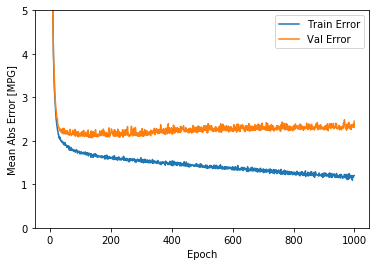

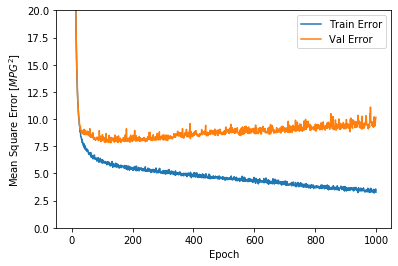

In [26]:
plot_history(history)

Train on 251 samples, validate on 63 samples
Epoch 1/1000
251/251 [==============================] - 0s 506us/sample - loss: 574.0740 - mae: 22.7019 - mse: 574.0740 - val_loss: 576.8868 - val_mae: 22.7439 - val_mse: 576.8868
Epoch 2/1000
251/251 [==============================] - 0s 45us/sample - loss: 538.7960 - mae: 21.9619 - mse: 538.7960 - val_loss: 537.3052 - val_mae: 21.8878 - val_mse: 537.3052
Epoch 3/1000
251/251 [==============================] - 0s 51us/sample - loss: 499.9686 - mae: 21.1115 - mse: 499.9686 - val_loss: 490.8831 - val_mae: 20.8469 - val_mse: 490.8831
Epoch 4/1000
251/251 [==============================] - 0s 57us/sample - loss: 455.5872 - mae: 20.0748 - mse: 455.5872 - val_loss: 435.5873 - val_mae: 19.5467 - val_mse: 435.5873
Epoch 5/1000
251/251 [==============================] - 0s 70us/sample - loss: 402.8475 - mae: 18.7880 - mse: 402.8475 - val_loss: 371.9091 - val_mae: 17.9248 - val_mse: 371.9091
Epoch 6/1000
251/251 [==============================] - 0s 

Epoch 47/1000
251/251 [==============================] - 0s 49us/sample - loss: 8.0093 - mae: 1.9786 - mse: 8.0093 - val_loss: 9.5397 - val_mae: 2.3736 - val_mse: 9.5397
Epoch 48/1000
251/251 [==============================] - 0s 44us/sample - loss: 7.9573 - mae: 1.9707 - mse: 7.9573 - val_loss: 9.5510 - val_mae: 2.3708 - val_mse: 9.5510
Epoch 49/1000
251/251 [==============================] - 0s 46us/sample - loss: 7.9136 - mae: 1.9606 - mse: 7.9136 - val_loss: 9.4733 - val_mae: 2.3686 - val_mse: 9.4733
Epoch 50/1000
251/251 [==============================] - 0s 43us/sample - loss: 7.8583 - mae: 1.9520 - mse: 7.8583 - val_loss: 9.4330 - val_mae: 2.3644 - val_mse: 9.4330
Epoch 51/1000
251/251 [==============================] - 0s 46us/sample - loss: 7.7938 - mae: 1.9537 - mse: 7.7938 - val_loss: 9.4543 - val_mae: 2.3506 - val_mse: 9.4543
Epoch 52/1000
251/251 [==============================] - 0s 45us/sample - loss: 7.7753 - mae: 1.9543 - mse: 7.7753 - val_loss: 9.4528 - val_mae: 2.339

251/251 [==============================] - 0s 38us/sample - loss: 6.6374 - mae: 1.8059 - mse: 6.6374 - val_loss: 8.7277 - val_mae: 2.2651 - val_mse: 8.7277
Epoch 96/1000
251/251 [==============================] - 0s 44us/sample - loss: 6.5780 - mae: 1.7993 - mse: 6.5780 - val_loss: 8.7199 - val_mae: 2.2427 - val_mse: 8.7199
Epoch 97/1000
251/251 [==============================] - 0s 44us/sample - loss: 6.5819 - mae: 1.8115 - mse: 6.5819 - val_loss: 8.7324 - val_mae: 2.2399 - val_mse: 8.7324
Epoch 98/1000
251/251 [==============================] - 0s 45us/sample - loss: 6.5475 - mae: 1.8082 - mse: 6.5475 - val_loss: 8.6940 - val_mae: 2.2403 - val_mse: 8.6940
Epoch 99/1000
251/251 [==============================] - 0s 42us/sample - loss: 6.5195 - mae: 1.7967 - mse: 6.5195 - val_loss: 8.6631 - val_mae: 2.2497 - val_mse: 8.6631
Epoch 100/1000
251/251 [==============================] - 0s 40us/sample - loss: 6.5256 - mae: 1.7920 - mse: 6.5256 - val_loss: 8.6395 - val_mae: 2.2524 - val_mse: 

251/251 [==============================] - 0s 43us/sample - loss: 5.8760 - mae: 1.6953 - mse: 5.8760 - val_loss: 8.3664 - val_mae: 2.2100 - val_mse: 8.3664
Epoch 144/1000
251/251 [==============================] - 0s 42us/sample - loss: 5.8786 - mae: 1.7005 - mse: 5.8786 - val_loss: 8.3975 - val_mae: 2.1943 - val_mse: 8.3975
Epoch 145/1000
251/251 [==============================] - 0s 46us/sample - loss: 5.8832 - mae: 1.7047 - mse: 5.8832 - val_loss: 8.4062 - val_mae: 2.2076 - val_mse: 8.4062
Epoch 146/1000
251/251 [==============================] - 0s 48us/sample - loss: 5.8452 - mae: 1.6866 - mse: 5.8452 - val_loss: 8.3671 - val_mae: 2.2098 - val_mse: 8.3671
Epoch 147/1000
251/251 [==============================] - 0s 45us/sample - loss: 5.9026 - mae: 1.6849 - mse: 5.9026 - val_loss: 8.3354 - val_mae: 2.2123 - val_mse: 8.3354
Epoch 148/1000
251/251 [==============================] - 0s 51us/sample - loss: 5.8479 - mae: 1.6798 - mse: 5.8479 - val_loss: 8.3050 - val_mae: 2.2059 - val_m

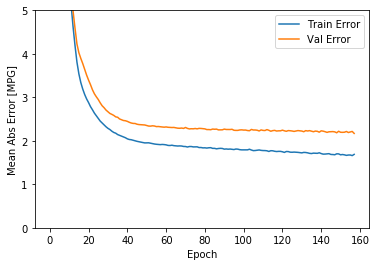

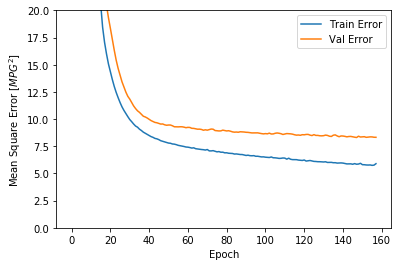

In [40]:
model = build_model()

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(normed_train_data, train_labels, epochs=EPOCHS, validation_split=0.2, callbacks = [early_stopping])

plot_history(history)

In [41]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae))

78/78 - 0s - loss: 5.6867 - mae: 1.8788 - mse: 5.6867
Testing set Mean Abs Error:  1.88 MPG


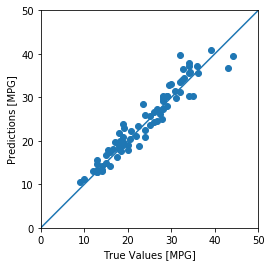

In [42]:
test_predictions = model.predict(normed_test_data).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)


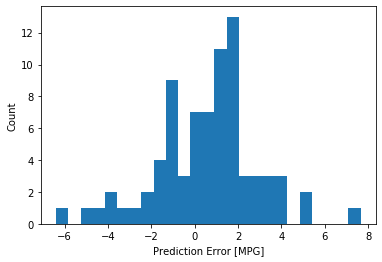

In [43]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")
